In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from simulations import lightcurve_simulation as lcsim
import visualize as vis
from detection import rnn_detection as rnndet
from detection import rnn_monodetection as mono

from wotan import flatten
from sklearn.metrics import mean_squared_error

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
rnn = torch.load("models/bigru1conf_w4sqrt_sim.pt")

In [7]:
np.random.seed(206)
# np.random.seed(0)
success = False
while not success:
    lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(.5,5.), dur_range=(0,utils.hour2day(13)))
    time, flux, pl_masks, params = lc
    success = params["planets"][0]["pl_transits"] == 1
mask = pl_masks[0]

mean, std = -0.10192371859533564, 2.6337997430623323
flux_ = ((flux-1) / params["sigma"] - mean) / std
pts, conf = rnndet.get_pts(rnn, flux_.reshape(1,-1), additional=True)

standard_det, conf_det = mono.monotransit_detection(pts, conf)

(0.0, 10.0)

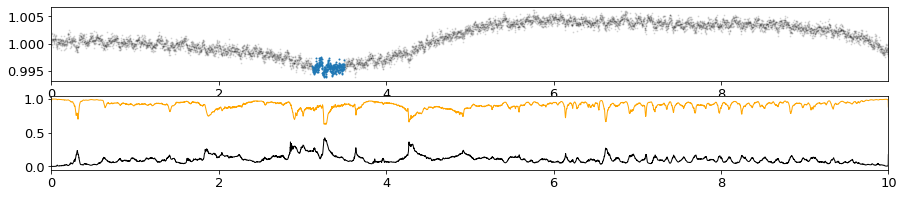

In [8]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
vis.plot(time[~mask], flux[~mask], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
plt.xlim(0,time[-1])
# plt.xlim(0,10)

plt.subplot(2,1,2)
vis.plot(time, pts, scatter=0)
vis.plot(time, conf, scatter=0, c="orange")
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
plt.xlim(0,time[-1])
plt.xlim(0,10)

In [5]:
standard_det

{0.89937425: {'t0': 0.4625, 'duration': 0.15416666666666673},
 0.9998659: {'t0': 6.770833333333334, 'duration': 0.3541666666666661}}

In [6]:
conf_det

{0.7120359: {'t0': 0.4625, 'duration': 0.15416666666666673},
 0.98894656: {'t0': 6.770833333333334, 'duration': 0.3541666666666661}}

#### BLS mono transit detection [TODO]

In [318]:
def get_monobox(time, t0, duration, depth):
    box = np.zeros_like(time)
    box[(time>=t0-duration/2.) & (time<=t0+duration/2.)] = -depth
    return box

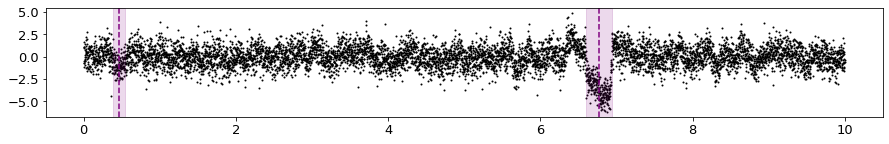

In [374]:
flat = (flatten(time, flux, method="median", window_length=1)-1)/params["sigma"]
plt.figure(figsize=(15,2))
vis.plot(time, flat)
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")

In [405]:
# durations = np.arange(1.,14,2)/24.
# step = 20
# depths = np.array([0.25,0.5,1,2,5]) / params["sigma"]

# snrs = np.zeros_like(time)
# mses = np.zeros_like(time) + 1e9
# t0s = np.zeros_like(time)
# durs = np.zeros_like(time)


# for duration in durations:   
#     dur_n = int(utils.day2min(duration)/2.)
#     indc = np.arange(dur_n)-step
#     for i in range(int((len(time)-dur_n)/step)+1):  
#         indc += step
#         score_indc = np.arange(step, dtype=int)+int(np.median(indc))-int(step/2.)
#         for depth in depths:
#             fit = np.zeros(len(time))
#             fit[indc] = depth
#             mse = mean_squared_error(flat, fit)
#             if mse < np.mean(mses[score_indc]):
#                 snr = depth * np.sqrt(dur_n)
#                 mses[score_indc] = mse
#                 snrs[score_indc] = snr
#                 t0s[score_indc] = time[score_i]
#                 durs[score_indc] = duration   